# Kats 101 - Basics

Kats (**K**its to **A**nalyze **T**ime **S**eries) is a light-weight, easy-to-use, extenable, and generalizable framework to perform time series analysis in Python.  Time series analysis is an essential component of data science and engineering work.  Kats aims to provide a one-stop shop for techniques for univariate and multivariate time series including:

1. Forecasting  
2. Anomaly and Change Point Detection  
3. Feature Extraction 


and after introducing the basic Kats data structure, this Kats 101 notebook provides a basic introduction to each of these time series techniques in Kats.  The complete table of contents for Kats 101 is as follows: 

1. Kats Basics          
    1.1 Initiate `TimeSeriesData` Object         
    1.2 `TimeSeriesData` built-in operations         
2. Forecasting with Kats         
    2.1 An example with Prophet model         
    2.2 An example with Theta model         
3. Detection with Kats         
    3.1 What are the algorithms?         
    3.2 An example with outlier detection method         
    3.3 An example with CUSUM algorithm         
4. Feature extraction with Kats         
5. Summary         

**Note:** We provide two types of tutorial notebooks
- **Kats 101**, basic data structure and functionalities in Kats (this tutorial)  
- **Kats 20x**, advanced topics, including advanced forecasting techniques, advanced detection algorithms, `TsFeatures`, meta-learning, etc. 

# 1. Kats Basics
`TimeSeriesData` is the basic data structure in Kats to represented univariate and multivariate time series.  There are two ways to initiate it, henceforth referred to as "Method 1" and "Method 2":

1) `TimeSeriesData(df)`, where `df` is a `pd.DataFrame` object with a "time" column and any number of value columns.

2) `TimeSeriesData(time, value)`, where `time` is either a `pd.Series` or `pd.DatetimeIndex` object and `value` is either a `pd.Series` (for univariate) or a `pd.DataFrame` (for multivariate)

## 1.1 Initiate `TimeSeriesData` object
We will use the `air_passenger` and `multi_ts` datasets to demonstrate how to create a `TimeSeriesData` object for univariate and multivariate time series, respectively.

In [1]:
%%capture
# For Google Colab:
!pip install kats
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/air_passengers.csv
!wget https://raw.githubusercontent.com/facebookresearch/Kats/main/kats/data/multi_ts.csv

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings('ignore')

from kats.consts import TimeSeriesData

In [3]:
try: # If running on Jupyter
    air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")
except FileNotFoundError: # If running on colab
    air_passengers_df = pd.read_csv("air_passengers.csv")

"""
Note: If the column holding the time values is not called "time", you will want to specify 
the name of this column using the time_col_name parameter in the TimeSeriesData constructor.
"""
air_passengers_df.columns = ["time", "value"]
air_passengers_df.head()

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [4]:
try: # If running on Jupyter
    multi_ts_df = pd.read_csv("../kats/data/multi_ts.csv", index_col=0)
except FileNotFoundError: # If running on colab
    multi_ts_df = pd.read_csv("multi_ts.csv", index_col=0)
multi_ts_df.columns = ["time", "v1", "v2"]
multi_ts_df.head()

,time,v1,v2
0,2017-03-12,-0.109,53.8
1,2017-03-13,0.000,53.6
2,2017-03-14,0.178,53.5
3,2017-03-15,0.339,53.5
4,2017-03-16,0.373,53.4


Here we construct `TimeSeriesData` objects for each time series using Method 1.

In [5]:
air_passengers_ts = TimeSeriesData(air_passengers_df)
multi_ts = TimeSeriesData(multi_ts_df)

In [6]:
# check that the type of the data is a "TimeSeriesData" object for both cases
print(type(air_passengers_ts))
print(type(multi_ts))

<class 'kats.consts.TimeSeriesData'>
<class 'kats.consts.TimeSeriesData'>


In [7]:
# For the air_passengers TimeSeriesData, check that both time and value are pd.Series
print(type(air_passengers_ts.time))
print(type(air_passengers_ts.value))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [8]:
# For the multi_ts TimeSeriesData, time is a pd.Series and value is a pd.DataFrame
print(type(multi_ts.time))
print(type(multi_ts.value))

<class 'pandas.core.series.Series'>
<class 'pandas.core.frame.DataFrame'>


Now, we show how to construct the same `TimeSeriesData` objects as before using Method 2.

In [9]:
air_passengers_ts_from_series = TimeSeriesData(time=air_passengers_df.time, value=air_passengers_df.value)
multi_ts_from_series = TimeSeriesData(time=multi_ts_df.time, value=multi_ts_df[['v1', 'v2']])

`TimeSeriesData` can accomodate time expressed as a variety of different types, including 
- standard `datetime`, 
- `pandas.Timestamp`,
- a `str` (if in a non-standard format or if efficiency is important, use the optional `date_format` argument),
- `int` (i.e. unix time).

Here is an example of how to construct a `TimeSeriesData` object when time is provided in unix time format.


Here's an example where the time is auto-interpreted from a unix time format. Using this format just requires a couple optional parameters in the `TimeSeriesData` constructor:
- `use_unix_time = True`
- `unix_time_units="s"` (the default is `"ns"`, indicating nanoseconds)

In [10]:
from dateutil import parser
from datetime import datetime

# Convert time from air_passengers data to unix time
air_passengers_ts_unixtime = air_passengers_df.time.apply(
    lambda x: datetime.timestamp(parser.parse(x))
)

air_passengers_ts_unixtime

0     -662662800.0
1     -659980800.0
2     -657561600.0
3     -654883200.0
4     -652291200.0
          ...     
139   -297190800.0
140   -294512400.0
141   -291916800.0
142   -289238400.0
143   -286646400.0
Name: time, Length: 144, dtype: float64

In [11]:
# Create the TimeSeriesData object with the extra arguments to accomodate unix time 
ts_from_unixtime = TimeSeriesData(
        time=air_passengers_ts_unixtime, 
        value=air_passengers_df.value, 
        use_unix_time=True, 
        unix_time_units="s"
)

ts_from_unixtime

,time,value
0,1949-01-01 07:00:00,112
1,1949-02-01 08:00:00,118
2,1949-03-01 08:00:00,132
3,1949-04-01 08:00:00,129
4,1949-05-01 08:00:00,121
...,...,...
139,1960-08-01 07:00:00,606
140,1960-09-01 07:00:00,508
141,1960-10-01 08:00:00,461
142,1960-11-01 08:00:00,390


## 1.2 `TimeSeriesData` built-in operations

The `TimeSeriesData` object supports many of the same operations of the standard `pandas.DataFrame`, including:
- Slicing
- Math Operations
- Extend 
- Plotting
- Utility Functions (`to_dataframe`, `to_array`, `is_empty`, `is_univariate`)

We give examples of each as follows.

## Slicing

In [12]:
air_passengers_ts[1:5]

,time,value
0,1949-02-01,118
1,1949-03-01,132
2,1949-04-01,129
3,1949-05-01,121


## Math operations

In [13]:
air_passengers_ts[1:5] + air_passengers_ts[1:5]

,time,value
0,1949-02-01,236
1,1949-03-01,264
2,1949-04-01,258
3,1949-05-01,242


In [14]:
# Equality and Inequality are also supported:

air_passengers_ts == air_passengers_ts_from_series

True

In [15]:
multi_ts == multi_ts_from_series

True

In [16]:
# length

len(air_passengers_ts)

144

## Extend

In [17]:
# Creating two slices
ts_1 = air_passengers_ts[0:3]
ts_2 = air_passengers_ts[3:7]

ts_1.extend(ts_2)
ts_1

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
5,1949-06-01,135
6,1949-07-01,148


## Plotting

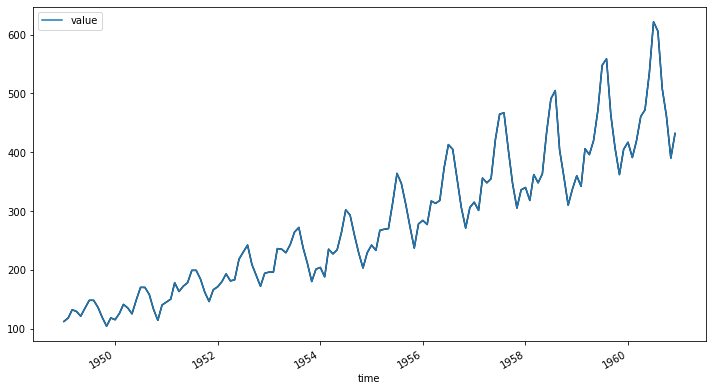

In [18]:
%matplotlib inline

# Must pass the name of the value columns to plot
air_passengers_ts.plot(cols=['value'])
plt.show()

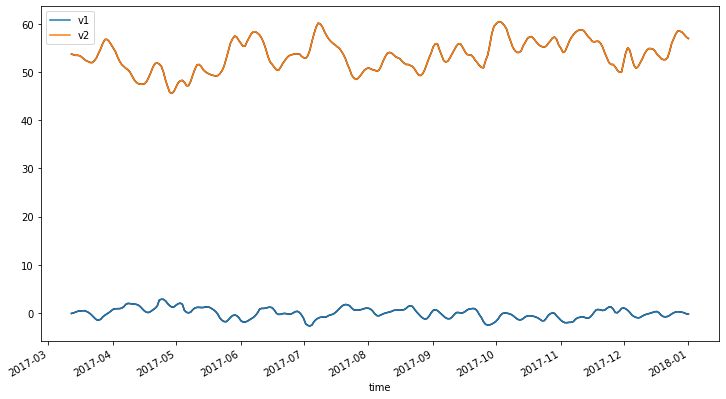

In [19]:
# We can plot multiple time series from multi_ts by passing in the name of each value column we want to plot
multi_ts.plot(cols=['v1','v2'])
plt.show()

## Utility functions

Here we provide examples of a few useful Kats utility functions for `TimeSeriesData`.  They can be helpful for working with external libraries.

### Convert to `pandas.DataFrame`

In [20]:
air_passengers_ts.to_dataframe().head()

,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


### Convert to `numpy.ndarray`

In [21]:
air_passengers_ts.to_array()[0:5]

array([[Timestamp('1949-01-01 00:00:00'), 112],
       [Timestamp('1949-02-01 00:00:00'), 118],
       [Timestamp('1949-03-01 00:00:00'), 132],
       [Timestamp('1949-04-01 00:00:00'), 129],
       [Timestamp('1949-05-01 00:00:00'), 121]], dtype=object)

### Check basic characteristics of the time series

In [22]:
air_passengers_ts.is_empty()

False

In [23]:
air_passengers_ts.is_univariate()

True

In [24]:
multi_ts.is_univariate()

False

# 2. Forecasting with Kats

We currently support the following 10 base forecasting models: 

1. Linear  
2. Quadratic   
3. ARIMA   
4. SARIMA   
5. Holt-Winters   
6. Prophet   
7. AR-Net   
8. LSTM   
9. Theta   
10. VAR   


Each models follows the `sklearn` model API pattern:  we create an instance of the model class and then call its `fit` and `predict` methods.  In this section, we provide examples for the Prophet and Theta models.  A more in-depth introduction to forecasting in Kats is provided in the Kats 201 tutorial.



## 2.1 An example with Prophet model

We will demonstrate how to use Prophet model to forecast with the `air_passengers` data set. Note: this example requires that fbprophet be installed (for example, `pip install kats[prophet]` or `pip install kats[all]`)

In [25]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [26]:
# the predict method returns a dataframe as follows
fcst.head()

,time,fcst,fcst_lower,fcst_upper
0,1961-01-01,451.152463,438.031293,464.303305
1,1961-02-01,432.553525,419.737356,444.677571
2,1961-03-01,491.921076,477.773706,505.889436
3,1961-04-01,494.501049,481.383321,507.426762
4,1961-05-01,503.407884,489.113097,516.624957


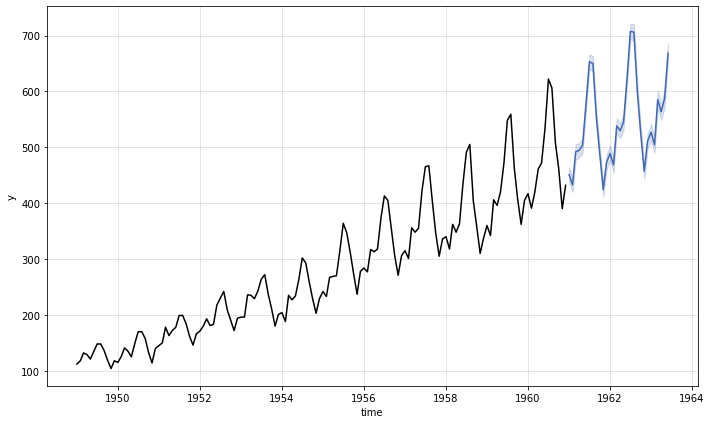

In [27]:
# visualize the results with uncertainty intervals
m.plot()

## 2.2 An example with Theta model


We will now use the Theta model to forecast with the `air_passengers` data set.  

The Theta Method (Assimakopoulos and Nikolopoulos, 2000) is a univariate forecasting method that fits two Theta lines: 1) a linear interpolation (called the `Theta=0`) and 2) a second-order difference (called the `Theta=2` line), and then combines them to build a forecast.  Prior to running this forecast, we test the time series for seasonality, deseaonalize if seasonality is detected, and then reseasonalize the calculated forecasts.  

Hyndman and Billah (2003) showed that the Theta Method is equivalent to simple exponential smoothing with drift.  In Kats we use this underlying model to calculate prediction intervals for `ThetaModel`.

Our implementation of `ThetaModel` in Kats is similar to the [thetaf function in R](https://pkg.robjhyndman.com/forecast/reference/thetaf.html).  Because each of our time series models follow the `sklearn` model API pattern, the code using `ThetaModel` is quite similar to the example above using 
`ProphetModel`: we initialize the model with its parameters and then call the `fit` and `predict` methods.  We can then use the `plot` method to visualize our forecast.

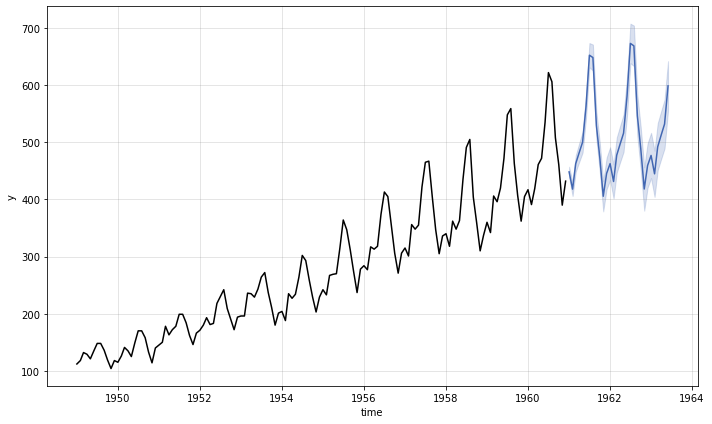

In [28]:
# import param and model from `kats.models.theta`
from kats.models.theta import ThetaModel, ThetaParams

# create ThetaParam with specifying seasonality param value
params = ThetaParams(m=12)

# create ThetaModel with given data and parameter class
m = ThetaModel(data=air_passengers_ts, params=params)

# call fit method to fit model
m.fit()

# call predict method to predict the next 30 steps
res = m.predict(steps=30, alpha=0.2)

# visualize the results
m.plot()

# 3. Detection with Kats

Kats provides a set of models and algorithms to detect outliers, change points, and trend changes in time series data.


## 3.1 What are the algorithms?

To detect a specific pattern, we provided different algorithms, which is summarized as follows.
- **Outlier Detection**. This usually refers to a abnormal spike in a time series data, which can be detected with `OutlierDetector`
- **Change Point Detection**. This refers to a sudden change that the time series have different statistical properties before and after the change. We provided three major algorithms to detect such patterns:
    - CUSUM Detection
    - Bayesian Online Change Point Detection (BOCPD)
    - Stat Sig Detection
- **Trend Change Detection**. This refers to a slow trend change on the time series data, which can be detected with Mann-Kendall detection algorithm, `MKDetector`

In this tutorial, we will demonstrate the usage of two detectors: `OutlierDetector` and `CUSUM`.  A more in-depth introduction to detection in Kats is provided in the Kats 202 tutorial.



## 3.2 An example with outlier detection method

We provide the `OutlierDetector` module to detect outliers in time series.  Since outliers can cause so many problems in downstream processing, it is important to be able to detect them.  `OutlierDetector` also provides functionality to handle or remove outliers once they are found.

Our outlier detection algorithm works as follows:

- We do a [seasonal decomposition](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) of the input time series with additive or multiplicative decomposition as specified (default is additive)
- We generate a residual time series by either removing only trend or both trend and seasonality if the seasonality is strong.
- We detect points in the residual which are outside 3 times the inter quartile range.  This multiplier can be tuned using the `iqr_mult` parameter in `OutlierDetector`.

Our example below copies the `air_passengers` data set and manually inserts outliers into it. We then use `OutlierDetector` to find them. 

In [29]:
# deep copy the air_passenger_df 
air_passengers_outlier_df = air_passengers_df.copy(deep=True)

# manually add outlier on the date of '1950-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1950-12-01','value']*=5
# manually add outlier on the date of '1959-12-01'
air_passengers_outlier_df.loc[air_passengers_outlier_df.time == '1959-12-01', 'value']*=4

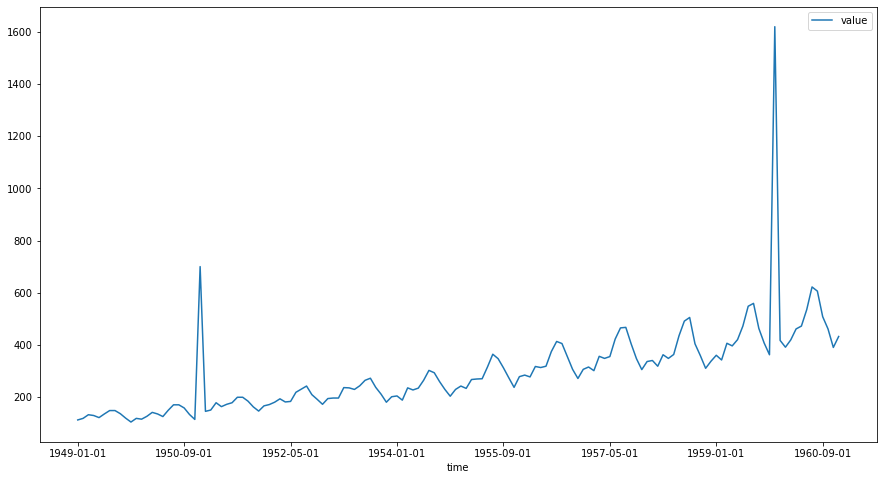

In [30]:
# visualize the raw data
air_passengers_outlier_df.plot(x='time', y='value', figsize=(15,8))
plt.show()

In [31]:
# transform the outlier data into `TimeSeriesData` Object
air_passengers_outlier_ts = TimeSeriesData(air_passengers_outlier_df)

In [32]:
from kats.detectors.outlier import OutlierDetector

ts_outlierDetection = OutlierDetector(air_passengers_outlier_ts, 'additive') # call OutlierDetector
ts_outlierDetection.detector() # apply OutlierDetector

Here we look at the outliers that the algorithum found.

In [33]:
ts_outlierDetection.outliers[0]

[Timestamp('1950-12-01 00:00:00'),
 Timestamp('1959-11-01 00:00:00'),
 Timestamp('1959-12-01 00:00:00')]

After detecting the outlier, we can now easily removal them from the data. Here we will explore two options: 
- **No Interpolation**: outlier data points will be replaced with **NaN** values
- **With Interpolation**: outlier data points will be replaced with **linear interploation** values

In [34]:
air_passengers_ts_outliers_removed = ts_outlierDetection.remover(interpolate = False) # No interpolation
air_passengers_ts_outliers_interpolated = ts_outlierDetection.remover(interpolate = True) # With interpolation

Here we visualize the difference between these two approaches to removing outliers.

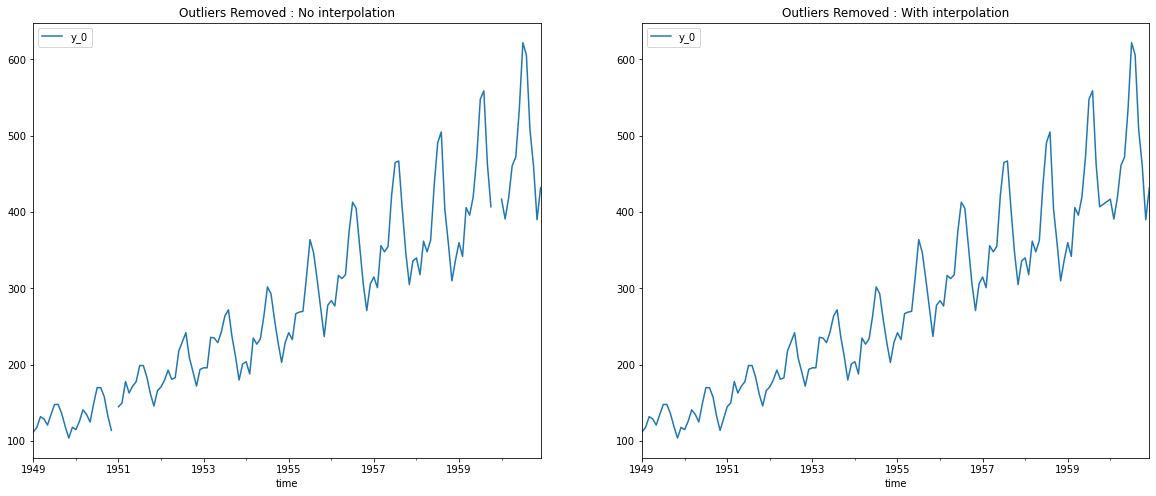

In [35]:
fig, ax = plt.subplots(figsize=(20,8), nrows=1, ncols=2)

air_passengers_ts_outliers_removed.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[0])
ax[0].set_title("Outliers Removed : No interpolation")
air_passengers_ts_outliers_interpolated.to_dataframe().plot(x = 'time',y = 'y_0', ax= ax[1])
ax[1].set_title("Outliers Removed : With interpolation")
plt.show()

## 3.3 An example with CUSUM algorithm

Cusum is a method to detect an up/down shift of means in a time series. Our implementation has two main steps:

1.  **Locate the change point:** This is an iterative process where we initialize a change point (in the middle of the time series) and CUSUM time series based on this change point.  The next changepoint is the location where the previous CUSUM time series is maximized (or minimized).  This iteration continues until either 1) a stable changepoint is found or 2) we exceed the limit number of iterations.

2.  **Test the change point for statistical significance:** Conduct log likelihood ratio test to test if the mean of the time series changes at the changepoint calculated in Step 1.  The null hypothesis is that there is no change in mean.

By default, we report a detected changepoint if and only if we reject the null hypothesis in Step 2.  

Here are a few additional points worth mentioning:
- We assume there is at most one increase change point and at most one decrease change point.  You can use the `change_directions` argument in the detector to specify whether you are looking an increase, a decrease, or both (default is both).
- We use Gaussian distribution as the underlying model to calculate the CUSUM time series value and conduct the hypothesis test.

In [36]:
# import packages
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.detectors.cusum_detection import CUSUMDetector

# synthesize data with simulation
np.random.seed(10)
df = pd.DataFrame(
    {
        'time': pd.date_range('2019-01-01', '2019-03-01'),
        'increase':np.concatenate([np.random.normal(1,0.2,30), np.random.normal(2,0.2,30)]),
        'decrease':np.concatenate([np.random.normal(1,0.3,50), np.random.normal(0.5,0.3,10)]),
    }
)

It is straightforward to use `CUSUMDetector` to detect an increase or a decrease when there is one.

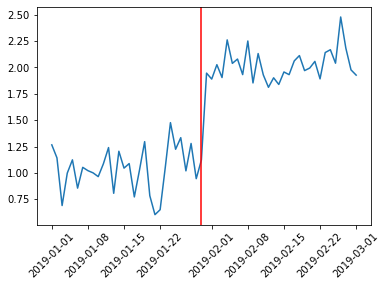

In [37]:
# detect increase
timeseries = TimeSeriesData(
    df.loc[:,['time','increase']]
)
detector = CUSUMDetector(timeseries)

# run detector
change_points = detector.detector(change_directions=["increase"])

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

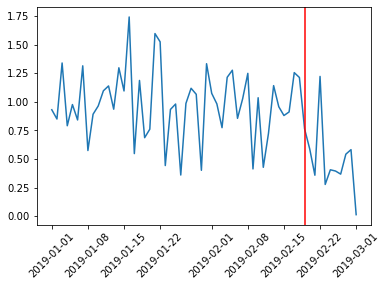

In [38]:
# detect decrease
timeseries = TimeSeriesData(
    df.loc[:,['time','decrease']]
)
detector = CUSUMDetector(timeseries)

# run detector
change_points = detector.detector(change_directions=["decrease"])

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

If we try to detect a decrease in a series where there is only an increase, no change point will be found.

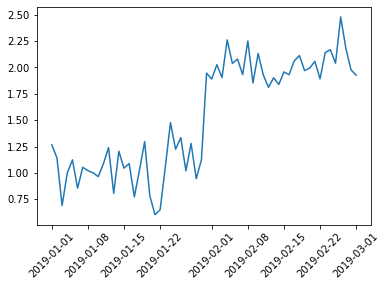

In [39]:
# detect increase
timeseries = TimeSeriesData(
    df.loc[:,['time','increase']]
)
detector = CUSUMDetector(timeseries)

# run detector
change_points = detector.detector(change_directions=["decrease"])

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

If we do not specify which change directions we are looking for, `CUSUMDetector` will look for both increases and decreases.  In the case below where there is only an increase, it will detect that increase.

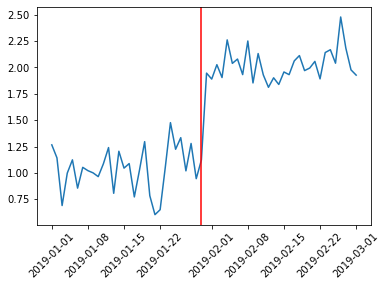

In [40]:
# detect increase
timeseries = TimeSeriesData(
    df.loc[:,['time','increase']]
)
detector = CUSUMDetector(timeseries)

# run detector
change_points = detector.detector()

# plot the results
plt.xticks(rotation=45)
detector.plot(change_points)
plt.show()

# 4. Feature Extraction with Kats

We provide the `TsFeatures` module to calculate a set of meaningful features for a time series, including:
- STL (Seasonal and Trend decomposition using Loess) Features
    - Strength of Seasonality
    - Strength of Trend
    - Spikiness
    - Linearity
- Amount of Level Shift
- Presence of Flat Segments
- ACF and PACF Features
- Hurst Exponent
- ARCH Statistic

Given a collection of time series, these features can be used to identify specific series that are similar or outlying.  Our `TsFeatures` module is similar to the one that is [freely available in R](https://pkg.robjhyndman.com/tsfeatures/index.html).

These features also play a crucial role in many downstream projects, including 
1. “Meta-learning”, i.e., choosing the best forecasting model based on characteristics of the input time series 
2. Time series classification and clustering analysis
3. Nowcasting algorithms for better short-term forecasting

Now we will show you how to use `TsFeatures` get the features for the `air_passenger` data set.

In [41]:
# Initiate feature extraction class
from kats.tsfeatures.tsfeatures import TsFeatures
tsFeatures = TsFeatures()

In [42]:
features_air_passengers = TsFeatures().transform(air_passengers_ts)

Now we can see the dictionary of features as follows.

In [43]:
# features_air_passengers
features_air_passengers

{'length': 144,
 'mean': 280.2986111111111,
 'var': 14291.97333140432,
 'entropy': 0.4287365561752448,
 'lumpiness': 3041164.5629058965,
 'stability': 12303.627266589507,
 'flat_spots': 2,
 'hurst': -0.08023291030513455,
 'std1st_der': 27.206287853461966,
 'crossing_points': 7,
 'binarize_mean': 0.4444444444444444,
 'unitroot_kpss': 0.12847508180149445,
 'heterogeneity': 126.06450625819339,
 'histogram_mode': 155.8,
 'linearity': 0.853638165603188,
 'trend_strength': 0.9383301875692747,
 'seasonality_strength': 0.3299338017939569,
 'spikiness': 111.69732482853489,
 'peak': 6,
 'trough': 3,
 'level_shift_idx': 118,
 'level_shift_size': 15.599999999999966,
 'y_acf1': 0.9480473407524915,
 'y_acf5': 3.392072131604336,
 'diff1y_acf1': 0.30285525815216935,
 'diff1y_acf5': 0.2594591065999471,
 'diff2y_acf1': -0.19100586757092733,
 'diff2y_acf5': 0.13420736423784568,
 'y_pacf5': 1.0032882494015292,
 'diff1y_pacf5': 0.21941234780081417,
 'diff2y_pacf5': 0.2610103428699484,
 'seas_acf1': 0.66290

# 5. Summary

in this tutorial, we have shown the basic operations of **Kats** in time series application, including basic introductions to forecasting, detection, feature extraction in Kats.

If you want to explore these topics in more detail, you can check out Kats 20x tutorials:

- [Kats 201 Forecasting with Kats](kats_201_forecasting.ipynb)
- [Kats 202 Detection with Kats](kats_202_detection.ipynb)
- [Kats 203 Time Series Features](kats_203_tsfeatures.ipynb)
- [Kats 204 Forecasting with Meta-Learning](kats_204_metalearning.ipynb)